In [1]:
from __future__ import print_function
from shapely.ops import cascaded_union
import geopandas as gpd
import descartes
import shapely.geometry as shy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import random
import igl
import math
import tripy
import networkx as nx
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib.pyplot import figure
colors= np.array(['#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E','#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E' ,'#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E'   ])
import copy
from numpy import linalg as LA
epsilon=1e-5


# part triangulation Functions

            

In [2]:
def triangulate(figure):
    result = np.array([tripy.earclip(figure[i]) for i in range(len(figure))])
    return result
def display_triangulated_shape(triangles):
    patches = []
    xmax=0
    ymax=0
    fig = plt.figure(num=None, figsize=(10, 6))
    ax = fig.gca()
    for i in range(len(triangles)):
        polygon = Polygon(triangles[i], fill=True,edgecolor='black',label='figure'+str(i))
        ax.add_artist(polygon)
    ax.set(xlim=(0, 1000), ylim=(0, 600))
    plt.show()
    


In [ ]:
1) line single direction
2 triangulate bounaray match 3


# parts display function

In [3]:
def displayPolygons(figure, v, k=0): 
    clone = copy.deepcopy(figure)
    def update(i=0):
        patches = []
        xmax=0
        ymax=0
        xmin =0
        ymin=0
        k=0
        fig2 = plt.figure(num=None, figsize=(10, 6))
        ax2 = fig2.gca()
        if(v.size>0):
            for k in range(len(figure)):
                for l in range(len(figure[k])):
                    clone[k][l][0]=figure[k][l][0] + i * v[2*k]
                    clone[k][l][1]=figure[k][l][1] + i * v[2*k+1]

        for i in range(len(figure)):
            polygon = Polygon(clone[i], fill=True, facecolor=colors[i],edgecolor='black',label='figure'+str(i))
            ax2.add_artist(polygon)
            if(xmax<np.max(clone[i][:,0])):
                xmax=np.max(clone[i][:,0])
            if(ymax<np.max(clone[i][:,1])):
                ymax=np.max(clone[i][:,1])
            if(xmin>np.min(clone[i][:,0])):
                xmin=np.min(clone[i][:,0])
            if(ymin>np.min(clone[i][:,1])):
                ymin=np.min(clone[i][:,1])
        ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
            

    interact(update,i=FloatSlider(min=0, max=10, step=0.1))
def simpleDisplay(figure):
    patches = []
    xmax=0
    ymax=0
    xmin =0
    ymin=0
    k=0
    fig2 = plt.figure(num=None, figsize=(10, 6))
    ax2 = fig2.gca()
    for i in range(len(figure)):
        polygon = Polygon(figure[i], fill=True, facecolor=colors[i],edgecolor='black',label='figure'+str(i))
        ax2.add_artist(polygon)
        if(xmax<np.max(figure[i][:,0])):
            xmax=np.max(figure[i][:,0])
        if(ymax<np.max(figure[i][:,1])):
            ymax=np.max(figure[i][:,1])
        if(xmin>np.min(figure[i][:,0])):
            xmin=np.min(figure[i][:,0])
        if(ymin>np.min(figure[i][:,1])):
            ymin=np.min(figure[i][:,1])
        ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    plt.show()

# normals computing functions

In [4]:
def cross(a,b):
    return a[0]*b[1]-b[0]*a[1]

def is_between(a, b, c): # is point c between point a and b
    if(np.allclose(a,c) or np.allclose(b,c)):
        return False
    cross_product= cross((c-a),(b-a))
    if abs(cross_product) > epsilon:
        return False
    dotproduct = (b-a)@(c-a)
    if dotproduct < 0:
        return False
    squaredlengthba = np.sum(np.square(b-a))
    if dotproduct > squaredlengthba:
        return False
    return True

def isTouching(v1,v2, u1,u2):
    if((np.allclose(v1,u1) and np.allclose(v2,u2)) or  (np.allclose(v2,u1) and np.allclose(v1,u2))):
        return True
    return abs(cross(v1-v2, u1-u2)) < epsilon and (is_between(v1,v2,u1) or is_between(v1,v2,u2) or is_between(u1,u2,v1) or is_between(u1,u2,v2))  
def compute_normal_edge(v1,v2):
    normal = np.array(v2-v1)
    normal[0], normal[1] = normal[1], -normal[0]
    normal = normal / LA.norm(normal)

    return np.around(np.array(normal), decimals = 3)

def compute_normals_shape(shape):
    normals_of_shape= np.array([compute_normal_edge(shape[i],shape[(i+1)%len(shape)]) for i in range(len(shape))])
    return normals_of_shape

def compute_normals_2_shapes(shape1, shape2): 
    result = np.array([compute_normal_edge(shape1[i],shape1[(i+1)%len(shape1)]) for i in range (len(shape1)) for j in range (len(shape2)) if(isTouching(shape1[i],shape1[(i+1)%len(shape1)],shape2[j],shape2[(j+1)%len(shape2)]))])   
    return set(tuple(i) for i in result)

def compute_normals_dict(figure):
    normals_dic = {}
    for i in range(len(figure)):
        for j in range(len(figure)):
            if(i != j):
                normals_dic[i,j]= compute_normals_2_shapes(figure[i], figure[j])
    return normals_dic

# inequation solver functions

In [5]:

def construct_A(figure):
    normals= compute_normals_dict(figure)
    count=0
    for x in normals: 
        count += len(normals[x]) 
    A = np.zeros((count,  len(figure)*2))
    c=0
    for x in normals:
        for j in range(len(normals[x])):
            a= list(normals[x])
            A[c][2*list(x)[0]]=-a[j][0]
            A[c][2*list(x)[0]+1]=-a[j][1]
            A[c][2*list(x)[1]]=a[j][0]
            A[c][2*list(x)[1]+1]=a[j][1]

            c=c+1
    return A

def solver(A, i): #fixes all velocities except the i part to 0
    x = cp.Variable(len(A[0]))
    tij=cp.Variable(len(A))
    index=np.arange(len(A[0]))
    index= np.delete(index, 2*i)
    index= np.delete(index, 2*i)

    constraints = [(A*x-tij)>=np.zeros(len(A)), x[index]==0, tij>=0, tij<=1]

    objective =  cp.Maximize(cp.sum(tij))
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return np.round(tij.value,decimals=3), np.round(x.value,decimals=3)

def solver_2(A, i,n, iskey=False,): #fixes only one reference part pr velocity to 0
    x = cp.Variable(len(A[0]))
    tij=cp.Variable(len(A))    
    if(iskey and n>2):
        constraints = [(A*x-tij)>=np.zeros(len(A)), x[(i+1)%len(A[0])]==0, x[i]==0, tij>=0, tij<=1]
    elif(n<=2):
        constraints = [(A*x-tij)>=np.zeros(len(A)),  tij>=0, tij<=1]
    else:
        constraints = [(A*x-tij)>=np.zeros(len(A)), x[(i+1)%len(A[0])]==0, tij>=0, tij<=1]

    objective =  cp.Maximize(cp.sum(tij))
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return np.round(tij.value,decimals=3), np.round(x.value,decimals=3)

# testing functions

In [6]:
def interlocking_test(figure, allVelocitiesFixed = True, key=None):
    A=construct_A(figure)
    final_v = np.array([])
    max_tij = np.zeros(len(A)) 
    
    for i in range(len(figure)):
        if(allVelocitiesFixed):
            temp_tij, v = solver(A, i)
        else:
            if(key is not None):
                temp_tij, v = solver_2(A, i,len(figure),True)
            else:
                temp_tij, v = solver_2(A, i,len(figure))

        if(np.sum(temp_tij) > np.sum(max_tij)):
            max_tij=temp_tij
            final_v=v
            
    return  max_tij, final_v   

def movingPieces(v):
    movingPieces=[]
    for i in range(len(v)//2):
        if(v[2*i]>0 or v[2*i+1]> 0):
            movingPieces.append(i)
    return movingPieces

def fullStudy(figure):
    tij, v= interlocking_test(figure, False)
    if(v.size>0):
        if(len(movingPieces(v))>1):
            displayPolygons(figure, v)
            return "non interlocking, figure {} are able to move together".format(movingPieces(v))
        else:
            print("only piece "+str(movingPieces(v))+" can move, it's the key")
            displayPolygons(figure,v)
            tij, v = interlocking_test(figure, False, movingPieces(v)[0])
            if(v.size!=0):
                print("it is an interlocking assembly ( deadlocking if key is fixed)")
                
    else:
        displayPolygons(figure,v)
        return "deadlocking"
        

# figure 1 test

In [7]:
#figure 1
p1 = np.array([[0,0], [400,0], [400,100],[100,100], [100,200], [200,300], [0,300]])
p2= np.array([[400,100],[400,300],[200,300],[100,200],[100,100]])
figure1= np.array([p1,p2])
fullStudy(figure1)

only piece [1] can move, it's the key


interactive(children=(FloatSlider(value=0.0, description='i', max=10.0), Output()), _dom_classes=('widget-inte…

it is an interlocking assembly ( deadlocking if key is fixed)


# figure 2 test

In [8]:
#figure 2
f1= np.array([[0,600],[0,200],[200,200],[100,100],[300,100],[800,600]])
f2= np.array([[0 ,0],[1000,0],[1000 , 600],[800, 600],[700 ,500],[800, 500],[700 ,400],[1000 , 400],[800 ,200],[400, 200],[300 ,100],[100 ,100],[200 ,200],[  0 ,200]])
f3= np.array([[400,200],[800,200],[1000,400],[700,400],[600,300],[500,300]])
f4= np.array([[500,300],[600,300], [800,500],[700,500]])
figure2=np.array([f1,f2,f3,f4])
fullStudy(figure2)

only piece [0] can move, it's the key


interactive(children=(FloatSlider(value=0.0, description='i', max=10.0), Output()), _dom_classes=('widget-inte…

it is an interlocking assembly ( deadlocking if key is fixed)


# Trivial test 

In [9]:
piece1 = np.array([[0,0],[1,0],[1,1],[0,1]])
piece2 = np.array([[1,0],[2,0],[2,1],[1,1]])
figureTrivial=np.array([piece1, piece2])
fullStudy(figureTrivial)

only piece [1] can move, it's the key


interactive(children=(FloatSlider(value=0.0, description='i', max=10.0), Output()), _dom_classes=('widget-inte…

it is an interlocking assembly ( deadlocking if key is fixed)


# DeadLocking test

In [10]:
deadLockingPart1 = np.array([[0,0],[300,0],[300,200],[200,200],[200,100],[100,100],[100,400],[200,400],[200,300],[300,300],[300,500],[0,500]])
deadLockingPart2 = np.array([[300,0],[400,0],[400,500],[300,500],[300,300],[200,300],[200,400],[100,400],[100,100],[200,100],[200,200],[300,200]])

deadLockingFigure=np.array([deadLockingPart1,deadLockingPart2])
fullStudy(deadLockingFigure)

interactive(children=(FloatSlider(value=0.0, description='i', max=10.0), Output()), _dom_classes=('widget-inte…

'deadlocking'

# triangle test

In [11]:
v1, f1 = igl.read_triangle_mesh("ressources/3-way-triangle/tri1.obj")
v2, f2 = igl.read_triangle_mesh("ressources/3-way-triangle/tri2.obj")
v3, f3 = igl.read_triangle_mesh("ressources/3-way-triangle/tri3.obj")
v1=np.flip(np.delete(v1, np.s_[1], 1), 0)
v2=np.flip(np.delete(v2, np.s_[1], 1), 0)
v3=np.flip(np.delete(v3, np.s_[1], 1), 0)
figureTriangle=np.array([v1,v2,v3])


In [12]:
fullStudy(figureTriangle)

interactive(children=(FloatSlider(value=0.0, description='i', max=10.0), Output()), _dom_classes=('widget-inte…

'non interlocking, figure [1, 2] are able to move together'

# DESIGNING PART

# global variables

In [356]:
baseGrid = [([shy.Polygon([(i,j),(i+1, j),(i+1,j+1),(i,j+1)]) for i in range(5) for j in range(5)])]
baseGridArr = np.array([([(i,j),(i+1, j),(i+1,j+1),(i,j+1)]) for i in range(5) for j in range(5)])
li= []
numberPieces = 4
keyIndexes = []
anchorIndexes = []
Graph = generateGridGraph(baseGridArr)
color_map = []
# triangulation of the grid
for i in range(len(baseGridArr)):
    li.append(tripy.earclip(baseGridArr[i])[0])
    li.append(tripy.earclip(baseGridArr[i])[1])
li=np.asarray(li)

# setup functions

In [ ]:

def isNeighboorsOf(shape1, shape2):
    #simpleDisplay(np.array([shape1,shape2]))
    for i in range(len(shape1)):
        for j in range(len(shape2)):
            if(isTouching(shape1[i],shape1[(i+1)%len(shape1)],shape2[j],shape2[(j+1)%len(shape2)])):
                return True
    return False

def generateGridGraph(grid):
    G = nx.Graph()
    for i in range(len(grid)):
        G.add_node(i)
    for i in range(len(grid)):
        for j in range(len(grid)):
            if(i!=j and isNeighboorsOf(grid[i],grid[j])):
                G.add_edge(i,j)
                G.add_edge(j,i)
    return G


def display(figure): 
    patches = []
    xmax=0
    ymax=0
    xmin =0
    ymin=0
    k=0
    fig = plt.figure(num=None, figsize=(10, 10))
    ax = fig.gca()
    for i in range(len(figure)):
        polygon = Polygon(figure[i],edgecolor='black', fill=True)
        ax.add_artist(polygon)
        if(xmax<np.max(figure[:,0])):
            xmax=np.max(figure[:,0])
        if(ymax<np.max(figure[:,1])):
            ymax=np.max(figure[:,1])
        if(xmin>np.min(figure[:,0])):
            xmin=np.min(figure[:,0])
        if(ymin>np.min(figure[:,1])):
            ymin=np.min(figure[:,1])
        ax.set(xlim=(xmin, 2*xmax), ylim=(ymin, 2*ymax))

    plt.show()



# polygons<->Grid functions

In [171]:
def createPieceFromPolygons(Ai):
    boundary = gpd.GeoSeries(cascaded_union(Ai))
    #boundary.plot(color = 'red')
    #plt.show()
    return boundary

def getCoordFromPolygon(polygon):
    d=shy.mapping(polygon)
    return (list(d.get('features')[0].get('geometry').get('coordinates')))

def getPolygonFromCoord(array):
    poly= [shy.Polygon(array[i]) for i in range(len(array))]
    return createPieceFromPolygons(poly)

def createPieceFromGrid(grid):
    grid = getCoordFromPolygon(getPolygonFromCoord(grid))
    grid = np.flip(grid, 1)
    grid = np.squeeze(grid,axis=0)
    return grid

 # voxel functions

In [357]:

def voxelAccessibility(x,j):
    global Graph
    alpha=0.1
    if(j==0):
        return len([n for n in Graph.neighbors(x) if n not in keyIndexes and n not in anchorIndexes ])
    else:
        return voxelAccessibility(x,j-1)+(alpha**j)*sumVA(x,j-1)
def sumVA(x,j):
    global Graph
    s = 0
    for  n in Graph.neighbors(x):
        s = s+ voxelAccessibility(n,j)
    return s

def pickSeedVoxel(Ai, v):
    seed = []
    k=0
    seedindex= []
    for i in range(len(Ai)):
        pk=Ai[i]
        pr= np.delete(Ai, i,0)
        pr = getCoordFromPolygon(getPolygonFromCoord(pr))
        if(len(pr)==1):
            
            pr=np.flip(pr,1)
            pr= np.squeeze(pr, axis=0)
            tij, vij =interlocking_test(np.array([pk,pr[1:]]), allVelocitiesFixed = True, key=None)
            if(np.allclose(v,vij)):
                seedindex.append(i)
    selectedSeed=seedindex[random.randint(0,len(seedindex)-1)]
    
    Rest = [Ai[i] for i in range(len(Ai)) if i != selectedSeed]
    return selectedSeed, Ai[selectedSeed], Rest

 

# Blocking/blockee functions

In [353]:
keyIndexes = [] # only here for debugging, reinitialize keyIndexes

#find the m lowest voxelaccessibilities from the n first bfs found neighboors.
def findBlockeeBlocking( Ai, vn, seedIndex,n, m ): 
    nNeighboorsList = list(nx.bfs_edges(Graph,seedIndex))[:n]
    BBList = []
    
    for i in range(len(nNeighboorsList)):
        if(nNeighboorsList[i][0]!=seedIndex and nNeighboorsList[i][1]!=seedIndex ):
            if((vn[0], vn[1]) in compute_normals_2_shapes(Ai[nNeighboorsList[i][0]], Ai[nNeighboorsList[i][1]])):
                BBList.append((nNeighboorsList[i]))
            if((vn[0], vn[1]) in compute_normals_2_shapes(Ai[nNeighboorsList[i][1]], Ai[nNeighboorsList[i][0]])):
                BBList.append((nNeighboorsList[i][1],nNeighboorsList[i][0]))
    accessibilityList = [voxelAccessibility(BBList[i][0],3) for i in range(len(BBList))]
    m= min(m, len(BBList))
    idx = np.argsort(accessibilityList)
    finalBBList= []
    for i in range(m):
        
        finalBBList.append(BBList[idx[i]])
    return finalBBList

#find All Shortest Path To Blockee Without Crossing Blocking
def sBBPath(BBList,seedIndex, graph):
    shortestPaths = []
    finalShortestPaths = []

    for i in range(len(BBList)):
        shortestPaths.append(list(nx.all_shortest_paths(graph, source=seedIndex, target=BBList[i][0])))
        finalShortestPaths.append(list(nx.all_shortest_paths(graph, source=seedIndex, target=BBList[i][0])))
        for j in range(len(shortestPaths[i])):
            if(BBList[i][1] in shortestPaths[i][j]):
                finalShortestPaths[i].remove(shortestPaths[i][j])
                
    return finalShortestPaths

def getMinLen(sP):
    tempMin = 10000
    candidate = None
    for i in range(len(sP)):
        if(len(sP[i])<tempMin and len(sP[i])>0):
            tempMin=len(sP[i])
            candidate= sP[i]
    return candidate


# anchor functions

In [358]:
def anchorScore(seedArray, blockingArray, vn):
    
    v = vn[:2]
    u = blockingArray[0]-seedArray[0]
    normU = np.linalg.norm(u)
    normV = np.linalg.norm(v)

    u = u / normU
    v = v / normV
    if(math.acos(np.dot(u,v))> math.pi/2 ):
        return 0
    return normU -  np.linalg.norm(u-v)
    
def getAnchorIndex(Ai, BBList, vn, seedIndex,blockingCandidate):
    
    maxBlockingAnchor = blockingCandidate
    score = anchorScore(Ai[seedIndex], Ai[blockingCandidate], vn)
    for i in range(len(BBList)):
        #print(anchorScore(Ai[seedIndex], Ai[BBList[i][1]], vn), "score of : ", BBList[i][1])
        if(anchorScore(Ai[seedIndex], Ai[BBList[i][1]], vn) > score):
            score = anchorScore(Ai[seedIndex], Ai[BBList[i][1]], vn)
            maxBlockingAnchor = BBList[i][1]
    
    return maxBlockingAnchor

# key generating functions

In [436]:
keyIndexes = []
def updateKey(Ai, sp, key):
    newKey = [key]
    global keyIndexes
    for i in range(len(sp[0])-1):
        newKey.append(Ai[sp[0][i+1]])
        keyIndexes.append(sp[0][i+1])
    print("key indexes : ", keyIndexes)
    Aicut = [Ai[i] for i in range(len(Ai)) if i not in sp[0]]
    return Aicut, np.asarray(newKey)



def pieceAbove(Ai,b, up):
    global keyIndexes
    global anchorIndexes
    listOfAboveNeigh = []
    neighbors = [n for n in Graph.neighbors(b)]
    for i in range(len(neighbors)):
        if(neighbors[i] not in keyIndexes and neighbors[i] not in anchorIndexes):
            for normals in compute_normals_2_shapes(Ai[b],Ai[neighbors[i]]):
                if (np.cross(normals, up)==0 and math.acos(np.dot(normals, up)/(np.linalg.norm(up)*np.linalg.norm(normals)))!= math.pi):
                    
                    listOfAboveNeigh.append(neighbors[i])
        if (len(listOfAboveNeigh) == 0):
            return []
    return listOfAboveNeigh


def uiPi(uiList): #uiList is the list of all ui which are lists of voxels
    sumI = 0
    beta = 2
    sumPi = 0
    piList = []
    length = 0
    for i in range(len(uiList)):
        sumI=0
        if(type(uiList[i])==int):
            sumI += voxelAccessibility(uiList[i], 3)    
        else:
            for j in range(len(uiList[i])):
                sumI += voxelAccessibility(uiList[i][j], 3)    
        pi = sumI**(-beta)
        sumPi += pi
        piList.append(pi)
    for i in range(len(piList)):
        piList[i]= piList[i] / sumPi
    return piList 
    
def expandKey(Ai):
    
    global keyIndexes
    UiCandidatesIndices = []
    graphContracted = Graph
    numberM = len(Ai) // numberPieces
    for i in range(len(keyIndexes)):
        graphContracted = nx.contracted_nodes(graphContracted, keyIndexes[0], keyIndexes[i])
    nx.draw(graphContracted, with_labels=True, font_weight='bold')

    neighbors = [n for n in graphContracted.neighbors(keyIndexes[0])]
    UiCandidatesList = []
    for i in range (len(neighbors)):
        templist = pieceAbove(Ai, neighbors[i], [0,1])        
        if(len(templist)==0):
            UiCandidatesList.append((neighbors[i]))
        elif(len(templist)>numberM-len(keyIndexes)): 
            continue
        else:
            templist.append(neighbors[i])
            UiCandidatesList.append(templist)
    UiCandidatesIndices = np.arange(len(UiCandidatesList))                             
    print("ui cand ilist " ,UiCandidatesList)
    probabilitiesList = uiPi(UiCandidatesList)
    randomIndex= np.random.choice(len(UiCandidatesList), len(UiCandidatesList), replace=False , p=probabilitiesList)

    while(len(randomIndex) != 0 and len(keyIndexes) < numberM ):
        if(type(UiCandidatesList[randomIndex[0]])!=int):
            if(len(UiCandidatesList[randomIndex[0]]) + len(keyIndex) >numberM):
                randomIndex = randomIndex[1:]
            else:
                print("appending",randomIndex[0], randomIndex)

                keyIndexes.append(UiCandidatesList[randomIndex[0]])
                randomIndex = randomIndex[1:]
        else:
            if(1 + len(keyIndexes) >numberM):
                randomIndex = randomIndex[1:]
            else:
                print("appending",randomIndex[0], randomIndex)
                keyIndexes.append(UiCandidatesList[randomIndex[0]])
                randomIndex = randomIndex[1:]
            
    print("new key is " , keyIndexes)

    
    
    return graphContracted

   
def generateKey(Ai):
    v = [0,1, 0,0] #up vector 
    vn = [1,0,0,0] #normal
    global keyIndexes
    global anchorIndexes
    seedIndex, seed , Aicut = pickSeedVoxel(Ai, v)
    keyIndexes.append(seedIndex)
    #simpleDisplay(np.array([createPieceFromGrid(Ai), seed]))
    BBList = findBlockeeBlocking(Ai,vn, seedIndex, 20, 10)
    shortestPaths = sBBPath(BBList, seedIndex,Graph)
    shortestPath = getMinLen(shortestPaths)
    nearestBlockee = shortestPath[-1][-1]
    nearestBlocking = 0
    
    for i in range(len(BBList)):
        if(BBList[0]== nearestBlockee):
            nearestBlocking = BBList[1]
    anchor = getAnchorIndex(Ai, BBList, vn, seedIndex, nearestBlocking)
    anchorIndexes.append(anchor)
    print("anchor index = ", anchor)
    Aicut , key= updateKey(Ai, shortestPath, seed)
    simpleDisplay(Aicut)
    simpleDisplay(key)
    expandKey(Ai)
    
    return None
    #return key, createPieceFromGrid(Ai)


# tests

anchor index =  24
key indexes :  [9, 14, 19]


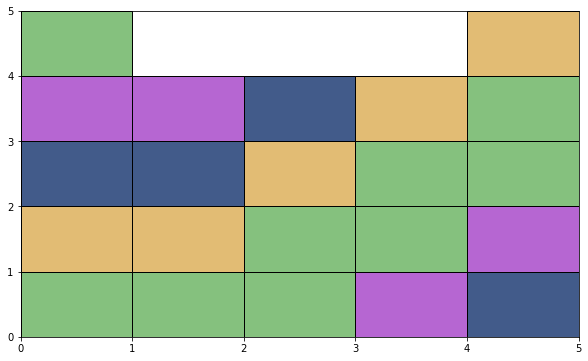

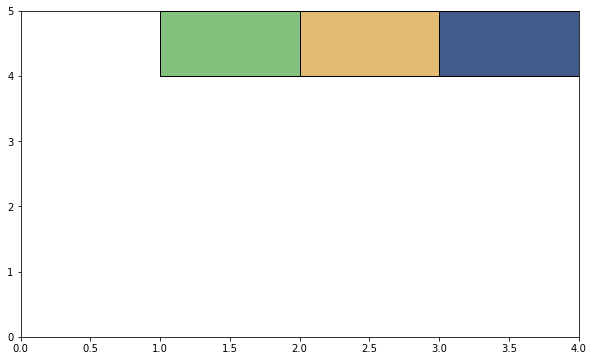

ui cand ilist  [4, 8, 13, 9, 18, 24]
appending 0 [0 2 5 3 1 4]
appending 2 [2 5 3 1 4]
appending 5 [5 3 1 4]
new key is  [9, 14, 19, 4, 13, 24]


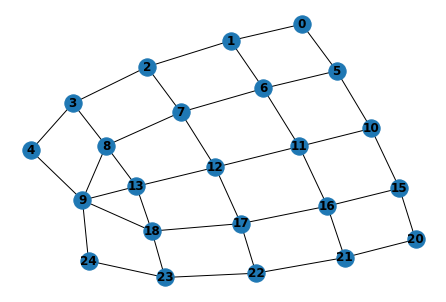

In [438]:
keyIndexes= []
generateKey(baseGridArr)

In [413]:

anchorScore(baseGridArr[14], baseGridArr[24], [1,0,0,0])

2.0

In [433]:
a = np.arange(8)


In [435]:
a = np.delete(a,a[0])
a

array([1, 3, 4, 5, 6, 7])

In [ ]:
findBlockeeBlocking( baseGridArr, [0,1,0,0], 14,18, 10 ) 

[5, 6, 7, 0, 4, 8]


/Users/Maxime/anaconda3/envs/joint/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


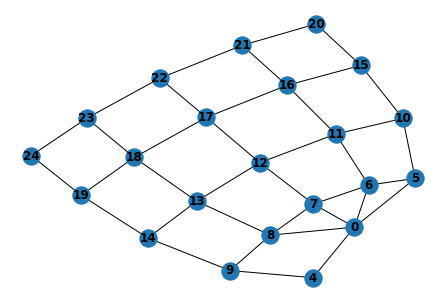

In [207]:
keyIndexes = [0,1,2,3]
nx.draw(expandKey(), with_labels=True, font_weight='bold')


In [ ]:
nx.draw(Graph, with_labels=True, font_weight='bold')


In [263]:

math.acos(np.dot([-2,0], [2,0])/4)

3.141592653589793

In [ ]:
def createInterlockAssembly(R0,n):
    i=0
    Ai=R0
    while(i<n):
        if(i==0):
            Aiplusone= generateKey(Ai)
            if(Aiplusone is None):
                return None
        else:
            generateParts(Ai)
        if(Aiplusone is not None):
            RankCandidates(Aiplusone)